In [261]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import datetime,gc,math
%matplotlib inline

In [262]:
def active_time_transform(df):
    df['role_created_3_active_time'].fillna('"0-8,0","8-12,0","12-14,0","14-18,0","18-24,0"', inplace=True)
    df['role_created_3_active_time'] = df['role_created_3_active_time'].apply(lambda x:str(x)[1:-1])
    temp = df['role_created_3_active_time'].str.split(',',expand=True).iloc[:,[1,3,5,7,9]].rename(columns={1:'active_0-8',
                                        3:'active_8-12',5:'active_12-14',7:'active_14-18',9:'active_18-24'})
    for i in range(len(temp.columns)):
        temp.iloc[:,i] = temp.iloc[:,i].apply(lambda x:str(x)[:-1])
    df = df.join(temp).drop(['role_created_3_active_time'], axis=1)
    return df

def pay_grade_transform(df):
    df['role_created_3_pay_grade'].fillna('[0,0,0,0,0,0,0]',inplace=True)
    from ast import literal_eval
    df['role_created_3_pay_grade'] = df['role_created_3_pay_grade'].apply(literal_eval)
    df = df.join(df['role_created_3_pay_grade'].apply(pd.Series)).rename(columns={0:'pay_grade_1',
                1:'pay_grade_2',2:'pay_grade_3',3:'pay_grade_4',4:'pay_grade_5',5:'pay_grade_6',6:'pay_grade_7'}).drop(['role_created_3_pay_grade'], axis=1)
    return df

In [263]:
%%time
role_info = pd.read_csv('./cp_role_info.csv')
role_info = active_time_transform(role_info)
role_info = pay_grade_transform(role_info)

Wall time: 24min 7s


In [264]:
role_info.to_pickle('./role_info_1.pickle')

In [578]:
role_info = pd.read_pickle('./role_info_1.pickle')

In [579]:
# 删除2020-7-19日前30天的数据
role_info['create_role_time'] = pd.to_datetime(role_info['create_role_time'], format='%Y-%m-%d %H:%M:%S')
role_info.drop(role_info[role_info['create_role_time'] > (role_info['create_role_time'].max() + 
                                                          datetime.timedelta(-30))].index,inplace=True)

In [580]:
pd.set_option('display.max_columns',None)
role_info = role_info.drop_duplicates()
print(role_info.shape)
# role_info.head(10)

(5150460, 30)


In [434]:
groups = role_info.groupby(['user_id','cp_server_no','cp_role_id'])
groups.ngroups

5088055

In [435]:
role_info.drop(['role_id'], axis=1, inplace=True)
role_info.drop_duplicates(subset=['user_id','cp_server_no','cp_role_id'], inplace=True)

In [436]:
# # 压缩数据
# def reduce_mem_usage(df, verbose=True):
#     numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
#     start_mem = df.memory_usage().sum() / 1024**2    
#     for col in df.columns:
#         col_type = df[col].dtypes
#         if col_type in numerics:
#             c_min = df[col].min()
#             c_max = df[col].max()
#             if str(col_type)[:3] == 'int':
#                 if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
#                     df[col] = df[col].astype(np.int8)
#                 elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
#                     df[col] = df[col].astype(np.int16)
#                 elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
#                     df[col] = df[col].astype(np.int32)
#                 elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
#                     df[col] = df[col].astype(np.int64)  
#             else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
#                     df[col] = df[col].astype(np.float32)
#                 else:
#                     df[col] = df[col].astype(np.float64)    
#     end_mem = df.memory_usage().sum() / 1024**2
#     if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
#     return df

# role_info = reduce_mem_usage(role_info)

In [437]:
# 删除同一user_id、cp_server_no、cp_role_id 相同但有两条数据的样本（650个）
# role_info = role_info.set_index(['user_id','cp_server_no','cp_role_id'], drop=False)
# temp = role_info.index.value_counts()
# temp = temp[temp>1]
# user_id = []
# for i in temp.index:
#     j = str(i[0])
#     user_id.append(j)
# role_info.drop(role_info[role_info['user_id'].isin(user_id)].index,inplace=True)
# role_info = role_info.reset_index(drop=True)

In [438]:
# 删除没有心跳数据的样本(1、没有登录;2、没有拿到心跳)
role_info.dropna(subset=['role_created_3_login_num'], inplace=True)
role_info.dropna(subset=['role_created_3_online'], inplace=True)
role_info['role_created_3_pay_num'].fillna(0, inplace=True)
role_info['role_created_3_pay_sum'].fillna(0, inplace=True)
role_info['role_created_3_active'] = role_info['role_created_3_active'].clip(0,3)
role_info['role_created_3_pay_rate'] = role_info['role_created_3_pay_num'] / (role_info['role_created_3_active'] + 1e-4)
role_info['role_created_3_pay_avg'] = role_info['role_created_3_pay_sum'] / (role_info['role_created_3_pay_num'] + 1e-4)

In [439]:
role_info_3d_pay = role_info[role_info['role_created_3_pay_num']>0]

In [440]:
role_info_3d_pay.shape

(105496, 31)

In [441]:
print('末日注册前3天付费总金额:',role_info_3d_pay['role_created_3_pay_sum'].sum())

末日注册前3天付费总金额: 25948112.0


### 清洗设备金额

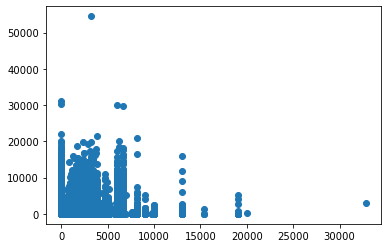

In [442]:
plt.scatter(role_info_3d_pay['model_money'], role_info_3d_pay['role_created_3_pay_sum'])
plt.show()

In [443]:
role_info_3d_pay.loc[role_info_3d_pay['p_model'] == 'iPhone 6s Plus','model_money'] = 3500
role_info_3d_pay.loc[role_info_3d_pay['p_model'] == 'iPhone12,1','model_money'] = 5000
role_info_3d_pay.loc[role_info_3d_pay['p_model'] == 'iPhone12,1','model_money'] = 2500
role_info_3d_pay.loc[role_info_3d_pay['p_model'] == 'iPhone12,1','model_money'] = 2000
role_info_3d_pay['model_money'] = role_info_3d_pay['model_money'].replace(0, np.nan)
role_info_3d_pay['model_money'].fillna(role_info_3d_pay[role_info_3d_pay['model_money'] !=0]['model_money'].mean(),inplace=True)

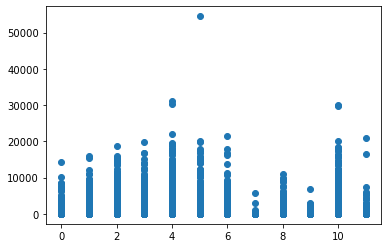

In [444]:
bins=[0,1000,1500,2000,2500,3000,3500,4000,4500,5000,6000,8000,10000]
role_info_3d_pay['model_money_level'] = pd.cut(role_info_3d_pay['model_money'],bins,labels=False)
plt.scatter(role_info_3d_pay['model_money_level'], role_info_3d_pay['role_created_3_pay_sum'])
plt.show()

In [445]:
temp = role_info[['model_money','role_created_3_pay_sum']]
temp.corr()

,model_money,role_created_3_pay_sum
model_money,1.000000,0.012689
role_created_3_pay_sum,0.012689,1.000000


### 清洗login_num

In [627]:
role_info_3d_pay['role_created_3_login_num'].mean()

30.903507423657057

In [628]:
role_info_3d_pay['role_created_3_max_role_level'].mean()

51.00420420350073

In [629]:
31/51

0.6078431372549019

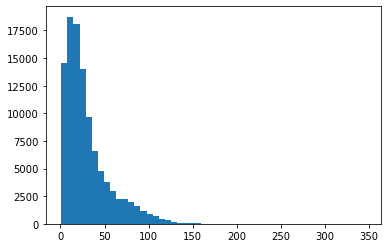

In [446]:
plt.hist(role_info_3d_pay[role_info_3d_pay['role_created_3_login_num']>0]['role_created_3_login_num'],bins=50)
plt.show
# 截取3登陆次数大于200的样本
role_info_3d_pay['role_created_3_login_num'].clip(1,120,inplace=True)
# 按等级补全在线时长
for i in role_info_3d_pay.index:
    if role_info_3d_pay.loc[i,'role_created_3_login_num'] <5:
        role_info_3d_pay.loc[i,'role_created_3_login_num'] = role_info_3d_pay.loc[i,'role_created_3_max_role_level'] * (
            role_info_3d_pay['role_created_3_login_num'].mean()/role_info_3d_pay['role_created_3_max_role_level'].mean())

<function matplotlib.pyplot.show(*args, **kw)>

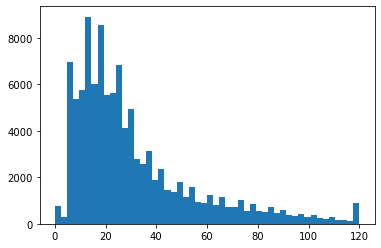

In [447]:
plt.hist(role_info_3d_pay['role_created_3_login_num'],bins=50)
plt.show

### 清洗max_role_level

<function matplotlib.pyplot.show(*args, **kw)>

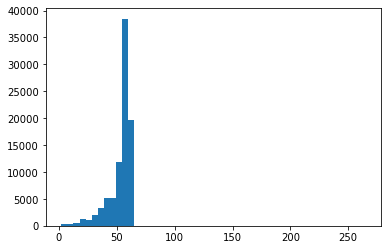

In [448]:
plt.hist(role_info_3d_pay[role_info_3d_pay['role_created_3_max_role_level']>1]['role_created_3_max_role_level'],bins=50)
plt.show

In [449]:
# # 按前3天充值金额更新等级小于20级的
# for i in role_info_3d_pay.index:
#     if role_info_3d_pay.loc[i,'role_created_3_max_role_level'] <20:
#         role_info_3d_pay.loc[i,'role_created_3_max_role_level'] = role_info_3d_pay.loc[i,'role_created_3_pay_sum'] * (
#             role_info_3d_pay['role_created_3_max_role_level'].mean()/role_info_3d_pay['role_created_3_pay_sum'].mean())
# # 截取等级大于65级的
# role_info_3d_pay['role_created_3_max_role_level'].clip(1,65,inplace=True)

In [630]:
role_info_3d_pay['role_created_3_max_role_level'].mean()/role_info_3d_pay['role_created_3_online'].mean()

0.0011020062891931698

In [450]:
# 按前3天在线时长更新等级小于20级的
for i in role_info_3d_pay.index:
    if role_info_3d_pay.loc[i,'role_created_3_max_role_level'] <20:
        role_info_3d_pay.loc[i,'role_created_3_max_role_level'] = role_info_3d_pay.loc[i,'role_created_3_online'] * (
            role_info_3d_pay['role_created_3_max_role_level'].mean()/role_info_3d_pay['role_created_3_online'].mean())
# 截取等级大于65级的
role_info_3d_pay['role_created_3_max_role_level'].clip(1,65,inplace=True)

<function matplotlib.pyplot.show(*args, **kw)>

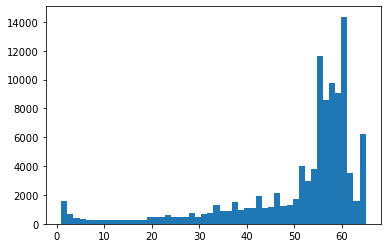

In [451]:
plt.hist(role_info_3d_pay['role_created_3_max_role_level'],bins=50)
plt.show

In [452]:
role_info_3d_pay[(role_info_3d_pay['role_created_3_max_role_level']<=5) & (role_info_3d_pay['role_created_3_online']>7200)].shape

(0, 32)

In [453]:
role_info_3d_pay[(role_info_3d_pay['role_created_3_max_role_level']<=5) & (role_info_3d_pay['role_created_3_online']>10800) & (role_info_3d_pay['role_created_3_pay_sum']>0)].shape

(0, 32)

### 清洗online

<function matplotlib.pyplot.show(*args, **kw)>

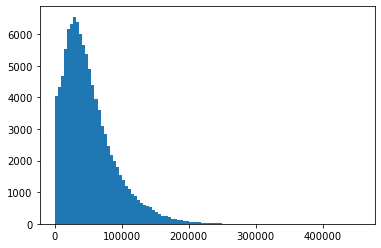

In [454]:
plt.hist(role_info_3d_pay['role_created_3_online'],bins=100)
plt.show

In [631]:
role_info_3d_pay['role_created_3_online'].mean()/role_info_3d_pay['role_created_3_max_role_level'].mean()

907.4358375324215

In [455]:
# 按等级补全在线时长
for i in role_info_3d_pay.index:
    if role_info_3d_pay.loc[i,'role_created_3_online'] <1800:
        role_info_3d_pay.loc[i,'role_created_3_online'] = role_info_3d_pay.loc[i,'role_created_3_max_role_level'] * (
            role_info_3d_pay['role_created_3_online'].mean()/role_info_3d_pay['role_created_3_max_role_level'].mean())
# 截断 最小5分钟，最大24小时
role_info_3d_pay['role_created_3_online'].clip(300,86400, inplace=True)

<function matplotlib.pyplot.show(*args, **kw)>

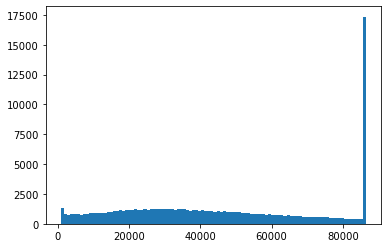

In [456]:
plt.hist(role_info_3d_pay['role_created_3_online'],bins=100)
plt.show

### 处理时间特征create_role_time

In [457]:
role_info_3d_pay = role_info_3d_pay.sort_values('create_role_time').reset_index(drop=True)

In [458]:
role_info_3d_pay.head()

,user_id,cp_server_no,cp_role_id,create_role_time,p_model,sys_ver,model_money,role_created_3_login_num,role_created_3_active,role_created_3_online,role_created_3_max_role_level,role_created_3_ip_num,role_created_3_device_num,role_created_3_city_num,role_created_3_pay_num,role_created_3_pay_sum,role_created_30_pay_sum,active_0-8,active_8-12,active_12-14,active_14-18,active_18-24,pay_grade_1,pay_grade_2,pay_grade_3,pay_grade_4,pay_grade_5,pay_grade_6,pay_grade_7,role_created_3_pay_rate,role_created_3_pay_avg,model_money_level
0,90002769,660011,12927624,2019-08-16 13:55:05,PBAM00,8.1.0,1149.00000,25.0,3.0,86400.0,58.0,3.0,1.0,1.0,1.0,30.0,30.0,116,68,24,47,56,0,1,0,0,0,0,0,0.333322,29.997000,1.0
1,90002917,660011,12927626,2019-08-16 13:56:00,ONEPLUS A6000,28,2743.72037,27.0,3.0,86400.0,60.0,2.0,1.0,1.0,7.0,266.0,1194.0,118,55,22,20,78,1,5,0,1,0,0,0,2.333256,37.999457,4.0
2,90006408,660011,12927734,2019-08-16 14:22:13,vivo X21A,9,2498.00000,7.0,3.0,53598.0,53.0,4.0,1.0,1.0,1.0,30.0,60.0,74,0,8,31,45,0,1,0,0,0,0,0,0.333322,29.997000,3.0
3,90007685,660011,12927757,2019-08-16 14:32:27,HWI-AL00,26,1528.50000,10.0,3.0,55722.0,53.0,3.0,2.0,1.0,1.0,12.0,12.0,26,2,5,1,28,0,1,0,0,0,0,0,0.333322,11.998800,2.0
4,90011968,660011,12927883,2019-08-16 15:14:06,JSN-AL00a,8.1.0,2743.72037,59.0,3.0,86400.0,60.0,9.0,1.0,2.0,5.0,108.0,176.0,97,72,37,114,83,1,4,0,0,0,0,0,1.666611,21.599568,4.0


In [459]:
role_info_3d_pay['hour'] = role_info_3d_pay['create_role_time'].dt.hour
role_info_3d_pay['weekend'] = role_info_3d_pay['create_role_time'].dt.weekday

In [508]:
holidays = ['2019-09-13','2019-09-14','2019-09-15','2019-10-01','2019-10-02','2019-10-03','2019-10-04','2019-10-05','2019-10-06','2019-10-07',
            '2020-01-01','2020-01-24','2020-01-25','2020-01-26','2020-01-27','2020-01-28','2020-01-29','2020-01-30','2020-04-04','2020-04-05',
            '2020-04-06','2020-04-04','2020-05-01','2020-05-02','2020-05-03','2020-05-04','2020-05-05','2020-06-25','2020-06-27']
role_info_3d_pay['timestamp'] = role_info_3d_pay['create_role_time'].dt.date.apply(lambda x:str(x))
role_info_3d_pay['is_holidays'] = (role_info_3d_pay['timestamp'].isin(holidays)).astype(int)
role_info_3d_pay['is_holidays'] = (role_info_3d_pay['timestamp'].isin(holidays)).astype(int)
role_info_3d_pay.drop(['timestamp'], axis=1, inplace=True)

## user_info

In [511]:
user_info = pd.read_csv('./user_info.csv')

In [514]:
user_info.drop_duplicates(inplace=True)

In [515]:
user_info.shape

(30226034, 10)

In [516]:
# 合并role_user
df_info_3d_pay = pd.merge(role_info_3d_pay,user_info,on='user_id',how='left',validate='many_to_one')

In [519]:
df_info_3d_pay.head()

,user_id,cp_server_no,cp_role_id,create_role_time,p_model,sys_ver,model_money,role_created_3_login_num,role_created_3_active,role_created_3_online,role_created_3_max_role_level,role_created_3_ip_num,role_created_3_device_num,role_created_3_city_num,role_created_3_pay_num,role_created_3_pay_sum,role_created_30_pay_sum,active_0-8,active_8-12,active_12-14,active_14-18,active_18-24,pay_grade_1,pay_grade_2,pay_grade_3,pay_grade_4,pay_grade_5,pay_grade_6,pay_grade_7,role_created_3_pay_rate,role_created_3_pay_avg,model_money_level,hour,weekend,is_holidays,timestamp,reg_date,mobile,user_type,user_flag,platform,channel_id,source_id,user_creates_3_server_num,user_creates_3_role_num
0,90002769,660011,12927624,2019-08-16 13:55:05,PBAM00,8.1.0,1149.00000,25.0,3.0,86400.0,58.0,3.0,1.0,1.0,1.0,30.0,30.0,116,68,24,47,56,0,1,0,0,0,0,0,0.333322,29.997000,1.0,13,4,0,2019-08-16,2019-08-16 13:54:49,NaN,1.0,1.0,1.0,6770.0,188588.0,1.0,1.0
1,90002917,660011,12927626,2019-08-16 13:56:00,ONEPLUS A6000,28,2743.72037,27.0,3.0,86400.0,60.0,2.0,1.0,1.0,7.0,266.0,1194.0,118,55,22,20,78,1,5,0,1,0,0,0,2.333256,37.999457,4.0,13,4,0,2019-08-16,2019-08-16 13:55:59,NaN,18.0,1.0,1.0,6867.0,198844.0,2.0,2.0
2,90006408,660011,12927734,2019-08-16 14:22:13,vivo X21A,9,2498.00000,7.0,3.0,53598.0,53.0,4.0,1.0,1.0,1.0,30.0,60.0,74,0,8,31,45,0,1,0,0,0,0,0,0.333322,29.997000,3.0,14,4,0,2019-08-16,2019-08-16 14:22:03,NaN,1.0,1.0,1.0,6770.0,191609.0,1.0,1.0
3,90007685,660011,12927757,2019-08-16 14:32:27,HWI-AL00,26,1528.50000,10.0,3.0,55722.0,53.0,3.0,2.0,1.0,1.0,12.0,12.0,26,2,5,1,28,0,1,0,0,0,0,0,0.333322,11.998800,2.0,14,4,0,2019-08-16,2019-08-16 14:32:26,NaN,18.0,1.0,1.0,6867.0,198844.0,1.0,1.0
4,90011968,660011,12927883,2019-08-16 15:14:06,JSN-AL00a,8.1.0,2743.72037,59.0,3.0,86400.0,60.0,9.0,1.0,2.0,5.0,108.0,176.0,97,72,37,114,83,1,4,0,0,0,0,0,1.666611,21.599568,4.0,15,4,0,2019-08-16,2019-08-16 15:14:00,NaN,1.0,1.0,1.0,20540.0,188172.0,1.0,1.0


In [520]:
# 标记用户时否绑定了手机，绑定;1    未绑定：0
df_info_3d_pay['mobile'] = pd.to_numeric(df_info_3d_pay['mobile'],errors='coerce')
df_info_3d_pay['mobile'] = df_info_3d_pay['mobile'].apply(lambda x:0 if np.isnan(x) == True else 1)

In [541]:
# 用户注册时间与角色注册时间的时间差,并进行分桶
df_info_3d_pay['reg_date'] = pd.to_datetime(df_info_3d_pay['reg_date'])
df_info_3d_pay['time_interval'] = (df_info_3d_pay['create_role_time'] - df_info_3d_pay['reg_date']).dt.total_seconds()/3600
df_info_3d_pay['time_interval'] = df_info_3d_pay['time_interval'].clip(0,2000)
df_info_3d_pay['time_interval'] = pd.cut(df_info_3d_pay['time_interval'], bins=[0,1,3,12,24,72,168,720,2000],labels=False)

In [553]:
df_info_3d_pay.head()

,user_id,cp_server_no,cp_role_id,create_role_time,p_model,sys_ver,model_money,role_created_3_login_num,role_created_3_active,role_created_3_online,role_created_3_max_role_level,role_created_3_ip_num,role_created_3_device_num,role_created_3_city_num,role_created_3_pay_num,role_created_3_pay_sum,role_created_30_pay_sum,active_0-8,active_8-12,active_12-14,active_14-18,active_18-24,pay_grade_1,pay_grade_2,pay_grade_3,pay_grade_4,pay_grade_5,pay_grade_6,pay_grade_7,role_created_3_pay_rate,role_created_3_pay_avg,model_money_level,hour,weekend,is_holidays,timestamp,reg_date,mobile,user_type,user_flag,platform,channel_id,source_id,user_creates_3_server_num,user_creates_3_role_num,user_role_timedate,time_interval
0,90002769,660011,12927624,2019-08-16 13:55:05,PBAM00,8.1.0,1149.00000,25.0,3.0,86400.0,58.0,3.0,1.0,1.0,1.0,30.0,30.0,116,68,24,47,56,0,1,0,0,0,0,0,0.333322,29.997000,1.0,13,4,0,2019-08-16,2019-08-16 13:54:49,0,1.0,1.0,1.0,6770.0,188588.0,1.0,1.0,16.0,0.0
1,90002917,660011,12927626,2019-08-16 13:56:00,ONEPLUS A6000,28,2743.72037,27.0,3.0,86400.0,60.0,2.0,1.0,1.0,7.0,266.0,1194.0,118,55,22,20,78,1,5,0,1,0,0,0,2.333256,37.999457,4.0,13,4,0,2019-08-16,2019-08-16 13:55:59,0,18.0,1.0,1.0,6867.0,198844.0,2.0,2.0,1.0,0.0
2,90006408,660011,12927734,2019-08-16 14:22:13,vivo X21A,9,2498.00000,7.0,3.0,53598.0,53.0,4.0,1.0,1.0,1.0,30.0,60.0,74,0,8,31,45,0,1,0,0,0,0,0,0.333322,29.997000,3.0,14,4,0,2019-08-16,2019-08-16 14:22:03,0,1.0,1.0,1.0,6770.0,191609.0,1.0,1.0,10.0,0.0
3,90007685,660011,12927757,2019-08-16 14:32:27,HWI-AL00,26,1528.50000,10.0,3.0,55722.0,53.0,3.0,2.0,1.0,1.0,12.0,12.0,26,2,5,1,28,0,1,0,0,0,0,0,0.333322,11.998800,2.0,14,4,0,2019-08-16,2019-08-16 14:32:26,0,18.0,1.0,1.0,6867.0,198844.0,1.0,1.0,1.0,0.0
4,90011968,660011,12927883,2019-08-16 15:14:06,JSN-AL00a,8.1.0,2743.72037,59.0,3.0,86400.0,60.0,9.0,1.0,2.0,5.0,108.0,176.0,97,72,37,114,83,1,4,0,0,0,0,0,1.666611,21.599568,4.0,15,4,0,2019-08-16,2019-08-16 15:14:00,0,1.0,1.0,1.0,20540.0,188172.0,1.0,1.0,6.0,0.0


In [554]:
df_info_3d_pay.columns

Index(['user_id', 'cp_server_no', 'cp_role_id', 'create_role_time', 'p_model',
       'sys_ver', 'model_money', 'role_created_3_login_num',
       'role_created_3_active', 'role_created_3_online',
       'role_created_3_max_role_level', 'role_created_3_ip_num',
       'role_created_3_device_num', 'role_created_3_city_num',
       'role_created_3_pay_num', 'role_created_3_pay_sum',
       'role_created_30_pay_sum', 'active_0-8', 'active_8-12', 'active_12-14',
       'active_14-18', 'active_18-24', 'pay_grade_1', 'pay_grade_2',
       'pay_grade_3', 'pay_grade_4', 'pay_grade_5', 'pay_grade_6',
       'pay_grade_7', 'role_created_3_pay_rate', 'role_created_3_pay_avg',
       'model_money_level', 'hour', 'weekend', 'is_holidays', 'timestamp',
       'reg_date', 'mobile', 'user_type', 'user_flag', 'platform',
       'channel_id', 'source_id', 'user_creates_3_server_num',
       'user_creates_3_role_num', 'user_role_timedate', 'time_interval'],
      dtype='object')

In [570]:
df_info_3d_pay['active_0-8'] = pd.to_numeric(df_info_3d_pay['active_0-8'], errors='coerce')
df_info_3d_pay['active_8-12'] = pd.to_numeric(df_info_3d_pay['active_8-12'], errors='coerce')
df_info_3d_pay['active_12-14'] = pd.to_numeric(df_info_3d_pay['active_12-14'], errors='coerce')
df_info_3d_pay['active_14-18'] = pd.to_numeric(df_info_3d_pay['active_14-18'], errors='coerce')
df_info_3d_pay['active_18-24'] = pd.to_numeric(df_info_3d_pay['active_18-24'], errors='coerce')

In [571]:
select_features = ['role_created_3_login_num',
       'role_created_3_active', 'role_created_3_online',
       'role_created_3_max_role_level', 'role_created_3_ip_num',
       'role_created_3_device_num',
       'role_created_3_pay_num', 'role_created_3_pay_sum', 'active_0-8', 'active_8-12', 'active_12-14',
       'active_14-18', 'active_18-24', 'pay_grade_1', 'pay_grade_2',
       'pay_grade_3', 'pay_grade_4', 'pay_grade_5', 'pay_grade_6',
       'pay_grade_7', 'role_created_3_pay_rate', 'role_created_3_pay_avg',
       'model_money_level', 'hour', 'weekend', 'is_holidays','mobile', 'user_type', 'user_flag', 'platform',
       'user_creates_3_server_num','user_creates_3_role_num', 'time_interval']
label = ['role_created_30_pay_sum']

In [557]:
import pandas as pd
import numpy as np
import random
import gc
import seaborn as sns
import lightgbm as lgb
from matplotlib import pyplot as plt
# import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,MinMaxScaler, StandardScaler
from sklearn.metrics import recall_score, auc, accuracy_score, f1_score, precision_score, classification_report, roc_auc_score,mean_squared_error
from pandas.api.types import is_categorical_dtype
from pandas.api.types import is_datetime64_any_dtype as is_datetime
# import missingno as msno
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [572]:
df_info_3d_pay_train, df_info_3d_pay_test = train_test_split(df_info_3d_pay, test_size=0.25)
target = df_info_3d_pay_train['role_created_30_pay_sum']
features = df_info_3d_pay_train[select_features]

In [577]:
target.describe()

count     79122.000000
mean        880.690529
std        4036.859780
min           6.000000
25%          30.000000
50%         102.000000
75%         368.000000
max      156788.000000
Name: role_created_30_pay_sum, dtype: float64

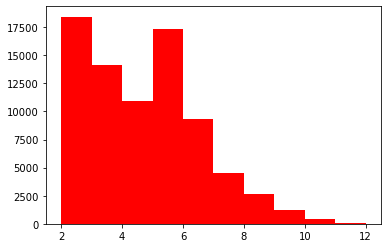

In [573]:
target_ln = np.log1p(target)
plt.hist(target_ln, color='red', range=(2, 12))
plt.show()

In [616]:
X_val, x_test, Y_val, y_test = train_test_split(features,target_ln, test_size=0.3)

In [617]:
params = {

"nthread":4,
"objective": "regression",
"boosting_type": "gbdt",
"learning_rate": 0.01,
"max_depth":7,
"num_leaves":5,
"max_bin":255,
"min_data_in_leaf":101,
"min_split_gain":1.0,
"feature_fraction": 1.0,
"bagging_fraction":0.6,
"bagging_freq":45,
"lambda_l1":1.0,
"lambda_l2":1.0,
"metric": "rmse",
}
train_data = lgb.Dataset(X_val, label=Y_val)
val_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
lgb_r_cv = lgb.train(params, train_data, num_boost_round=8000, early_stopping_rounds=100, valid_sets=[train_data, val_data])

[1]	training's rmse: 1.79327	valid_1's rmse: 1.78793
Training until validation scores don't improve for 100 rounds
[2]	training's rmse: 1.78143	valid_1's rmse: 1.77607
[3]	training's rmse: 1.76974	valid_1's rmse: 1.76439
[4]	training's rmse: 1.75821	valid_1's rmse: 1.75288
[5]	training's rmse: 1.74683	valid_1's rmse: 1.7415
[6]	training's rmse: 1.73566	valid_1's rmse: 1.73033
[7]	training's rmse: 1.72456	valid_1's rmse: 1.71926
[8]	training's rmse: 1.71361	valid_1's rmse: 1.70832
[9]	training's rmse: 1.70273	valid_1's rmse: 1.69746
[10]	training's rmse: 1.69199	valid_1's rmse: 1.68674
[11]	training's rmse: 1.6814	valid_1's rmse: 1.67615
[12]	training's rmse: 1.67093	valid_1's rmse: 1.66571
[13]	training's rmse: 1.66062	valid_1's rmse: 1.65542
[14]	training's rmse: 1.65043	valid_1's rmse: 1.64525
[15]	training's rmse: 1.64044	valid_1's rmse: 1.6353
[16]	training's rmse: 1.63056	valid_1's rmse: 1.62544
[17]	training's rmse: 1.62078	valid_1's rmse: 1.61568
[18]	training's rmse: 1.6111	val

[226]	training's rmse: 0.982894	valid_1's rmse: 0.984516
[227]	training's rmse: 0.982443	valid_1's rmse: 0.984089
[228]	training's rmse: 0.981992	valid_1's rmse: 0.983658
[229]	training's rmse: 0.981554	valid_1's rmse: 0.98324
[230]	training's rmse: 0.981127	valid_1's rmse: 0.982837
[231]	training's rmse: 0.9807	valid_1's rmse: 0.982429
[232]	training's rmse: 0.980297	valid_1's rmse: 0.982039
[233]	training's rmse: 0.979887	valid_1's rmse: 0.981647
[234]	training's rmse: 0.979478	valid_1's rmse: 0.98125
[235]	training's rmse: 0.97909	valid_1's rmse: 0.980881
[236]	training's rmse: 0.978702	valid_1's rmse: 0.980515
[237]	training's rmse: 0.978315	valid_1's rmse: 0.980145
[238]	training's rmse: 0.977939	valid_1's rmse: 0.979782
[239]	training's rmse: 0.977558	valid_1's rmse: 0.979408
[240]	training's rmse: 0.977193	valid_1's rmse: 0.97906
[241]	training's rmse: 0.976847	valid_1's rmse: 0.978736
[242]	training's rmse: 0.976487	valid_1's rmse: 0.978387
[243]	training's rmse: 0.976135	valid

[458]	training's rmse: 0.946056	valid_1's rmse: 0.949396
[459]	training's rmse: 0.946009	valid_1's rmse: 0.949348
[460]	training's rmse: 0.945958	valid_1's rmse: 0.9493
[461]	training's rmse: 0.945912	valid_1's rmse: 0.949259
[462]	training's rmse: 0.945867	valid_1's rmse: 0.949212
[463]	training's rmse: 0.945823	valid_1's rmse: 0.949166
[464]	training's rmse: 0.945772	valid_1's rmse: 0.949116
[465]	training's rmse: 0.945728	valid_1's rmse: 0.949076
[466]	training's rmse: 0.94568	valid_1's rmse: 0.949034
[467]	training's rmse: 0.945638	valid_1's rmse: 0.94899
[468]	training's rmse: 0.945589	valid_1's rmse: 0.948942
[469]	training's rmse: 0.94554	valid_1's rmse: 0.9489
[470]	training's rmse: 0.945499	valid_1's rmse: 0.948857
[471]	training's rmse: 0.945453	valid_1's rmse: 0.948813
[472]	training's rmse: 0.945397	valid_1's rmse: 0.948755
[473]	training's rmse: 0.94535	valid_1's rmse: 0.948714
[474]	training's rmse: 0.945309	valid_1's rmse: 0.948669
[475]	training's rmse: 0.945269	valid_1

[674]	training's rmse: 0.940281	valid_1's rmse: 0.944348
[675]	training's rmse: 0.940267	valid_1's rmse: 0.944333
[676]	training's rmse: 0.940252	valid_1's rmse: 0.94433
[677]	training's rmse: 0.940236	valid_1's rmse: 0.944327
[678]	training's rmse: 0.940221	valid_1's rmse: 0.944317
[679]	training's rmse: 0.940206	valid_1's rmse: 0.944314
[680]	training's rmse: 0.940192	valid_1's rmse: 0.944304
[681]	training's rmse: 0.940178	valid_1's rmse: 0.944302
[682]	training's rmse: 0.940164	valid_1's rmse: 0.944294
[683]	training's rmse: 0.94015	valid_1's rmse: 0.944292
[684]	training's rmse: 0.940137	valid_1's rmse: 0.944283
[685]	training's rmse: 0.940124	valid_1's rmse: 0.944281
[686]	training's rmse: 0.940111	valid_1's rmse: 0.944274
[687]	training's rmse: 0.940098	valid_1's rmse: 0.944273
[688]	training's rmse: 0.940086	valid_1's rmse: 0.944264
[689]	training's rmse: 0.940069	valid_1's rmse: 0.944249
[690]	training's rmse: 0.940052	valid_1's rmse: 0.944235
[691]	training's rmse: 0.94004	va

[947]	training's rmse: 0.937595	valid_1's rmse: 0.942792
[948]	training's rmse: 0.937586	valid_1's rmse: 0.942787
[949]	training's rmse: 0.937578	valid_1's rmse: 0.942783
[950]	training's rmse: 0.937569	valid_1's rmse: 0.942778
[951]	training's rmse: 0.937561	valid_1's rmse: 0.942774
[952]	training's rmse: 0.937552	valid_1's rmse: 0.942769
[953]	training's rmse: 0.937545	valid_1's rmse: 0.942768
[954]	training's rmse: 0.937537	valid_1's rmse: 0.942765
[955]	training's rmse: 0.937529	valid_1's rmse: 0.94276
[956]	training's rmse: 0.937523	valid_1's rmse: 0.942759
[957]	training's rmse: 0.937515	valid_1's rmse: 0.942756
[958]	training's rmse: 0.937507	valid_1's rmse: 0.942752
[959]	training's rmse: 0.9375	valid_1's rmse: 0.942752
[960]	training's rmse: 0.937494	valid_1's rmse: 0.942751
[961]	training's rmse: 0.937487	valid_1's rmse: 0.94275
[962]	training's rmse: 0.937479	valid_1's rmse: 0.942746
[963]	training's rmse: 0.937472	valid_1's rmse: 0.942746
[964]	training's rmse: 0.937462	val

[1091]	training's rmse: 0.936415	valid_1's rmse: 0.942284
[1092]	training's rmse: 0.936409	valid_1's rmse: 0.942282
[1093]	training's rmse: 0.936402	valid_1's rmse: 0.942281
[1094]	training's rmse: 0.936395	valid_1's rmse: 0.942279
[1095]	training's rmse: 0.936389	valid_1's rmse: 0.942278
[1096]	training's rmse: 0.936382	valid_1's rmse: 0.942277
[1097]	training's rmse: 0.936375	valid_1's rmse: 0.942271
[1098]	training's rmse: 0.936367	valid_1's rmse: 0.942269
[1099]	training's rmse: 0.936357	valid_1's rmse: 0.942261
[1100]	training's rmse: 0.936352	valid_1's rmse: 0.94226
[1101]	training's rmse: 0.936343	valid_1's rmse: 0.942252
[1102]	training's rmse: 0.936334	valid_1's rmse: 0.942249
[1103]	training's rmse: 0.936325	valid_1's rmse: 0.942242
[1104]	training's rmse: 0.93632	valid_1's rmse: 0.942241
[1105]	training's rmse: 0.936311	valid_1's rmse: 0.942234
[1106]	training's rmse: 0.936306	valid_1's rmse: 0.942233
[1107]	training's rmse: 0.936297	valid_1's rmse: 0.942226
[1108]	training'

[1367]	training's rmse: 0.934617	valid_1's rmse: 0.94152
[1368]	training's rmse: 0.934608	valid_1's rmse: 0.941516
[1369]	training's rmse: 0.934603	valid_1's rmse: 0.941517
[1370]	training's rmse: 0.934596	valid_1's rmse: 0.941517
[1371]	training's rmse: 0.934588	valid_1's rmse: 0.941512
[1372]	training's rmse: 0.934578	valid_1's rmse: 0.941504
[1373]	training's rmse: 0.934572	valid_1's rmse: 0.9415
[1374]	training's rmse: 0.934569	valid_1's rmse: 0.9415
[1375]	training's rmse: 0.934562	valid_1's rmse: 0.9415
[1376]	training's rmse: 0.934557	valid_1's rmse: 0.941501
[1377]	training's rmse: 0.934548	valid_1's rmse: 0.941493
[1378]	training's rmse: 0.934545	valid_1's rmse: 0.941493
[1379]	training's rmse: 0.934536	valid_1's rmse: 0.94149
[1380]	training's rmse: 0.934529	valid_1's rmse: 0.941487
[1381]	training's rmse: 0.934522	valid_1's rmse: 0.94149
[1382]	training's rmse: 0.934519	valid_1's rmse: 0.94149
[1383]	training's rmse: 0.934512	valid_1's rmse: 0.94149
[1384]	training's rmse: 0

[1523]	training's rmse: 0.933914	valid_1's rmse: 0.94132
[1524]	training's rmse: 0.933909	valid_1's rmse: 0.94132
[1525]	training's rmse: 0.933903	valid_1's rmse: 0.941317
[1526]	training's rmse: 0.9339	valid_1's rmse: 0.941315
[1527]	training's rmse: 0.933894	valid_1's rmse: 0.941312
[1528]	training's rmse: 0.933891	valid_1's rmse: 0.94131
[1529]	training's rmse: 0.933885	valid_1's rmse: 0.941308
[1530]	training's rmse: 0.933881	valid_1's rmse: 0.941308
[1531]	training's rmse: 0.933876	valid_1's rmse: 0.941307
[1532]	training's rmse: 0.933871	valid_1's rmse: 0.941307
[1533]	training's rmse: 0.933867	valid_1's rmse: 0.941307
[1534]	training's rmse: 0.933862	valid_1's rmse: 0.941307
[1535]	training's rmse: 0.933858	valid_1's rmse: 0.941306
[1536]	training's rmse: 0.933855	valid_1's rmse: 0.941305
[1537]	training's rmse: 0.933851	valid_1's rmse: 0.941304
[1538]	training's rmse: 0.933848	valid_1's rmse: 0.941304
[1539]	training's rmse: 0.933845	valid_1's rmse: 0.941303
[1540]	training's r

[1665]	training's rmse: 0.933297	valid_1's rmse: 0.941128
[1666]	training's rmse: 0.93329	valid_1's rmse: 0.941127
[1667]	training's rmse: 0.933283	valid_1's rmse: 0.941125
[1668]	training's rmse: 0.933277	valid_1's rmse: 0.941124
[1669]	training's rmse: 0.933271	valid_1's rmse: 0.941124
[1670]	training's rmse: 0.933265	valid_1's rmse: 0.941123
[1671]	training's rmse: 0.933261	valid_1's rmse: 0.941123
[1672]	training's rmse: 0.933255	valid_1's rmse: 0.941123
[1673]	training's rmse: 0.933251	valid_1's rmse: 0.941123
[1674]	training's rmse: 0.933245	valid_1's rmse: 0.941122
[1675]	training's rmse: 0.933241	valid_1's rmse: 0.941123
[1676]	training's rmse: 0.933236	valid_1's rmse: 0.941123
[1677]	training's rmse: 0.933232	valid_1's rmse: 0.941124
[1678]	training's rmse: 0.933227	valid_1's rmse: 0.941123
[1679]	training's rmse: 0.933223	valid_1's rmse: 0.941122
[1680]	training's rmse: 0.933218	valid_1's rmse: 0.941122
[1681]	training's rmse: 0.933213	valid_1's rmse: 0.941121
[1682]	training

In [623]:
y_predict = lgb_r_cv.predict(x_test)
y_predict = np.expm1(y_predict) * 1.55
mse = mean_squared_error(y_predict, np.expm1(y_test))
mae = mean_absolute_error(y_predict, np.expm1(y_test))
rmse = mse ** 0.5
print(rmse)
print(mse)
print(mae)

2704.8399749115742
7316159.289879646
642.8617329158743


In [624]:
sum(y_predict)

20366125.161445316

In [625]:
sum(np.expm1(y_test))

20489848.0

In [626]:
sum(y_predict)/sum(np.expm1(y_test))

0.9939617493231436

In [586]:
role_info['role_created_30_pay_sum'].sum()


118149856.0

In [587]:
role_info['role_created_30_pay_sum'].mean()

882.7825879047804

In [588]:
role_info_3d_pay['role_created_30_pay_sum'].sum()

93439049.0

In [589]:
role_info_3d_pay['role_created_30_pay_sum'].sum()/role_info['role_created_30_pay_sum'].sum()

0.7908519922360294

In [590]:
role_info_3d_pay['role_created_30_pay_sum'].mean()

885.71177106241

In [592]:
np.mean(np.expm1(y_predict))

576.309944065495

In [593]:
882/576

1.53125